In [32]:
import numpy as np
import pandas as pd
import coupled_LDS
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import autograd.numpy as anp 
import os
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
from coupled_LDS import *
from EI_subspace_RNN import * 
import seaborn
seaborn.set_context("talk")

K1 = 2 
K2 = 5

# Generate EI RNN

In [34]:
U = 1000
T = 100
K = K1 + K2
D = 50
M = 2
N_e = int(D / 2) # number of units in the RNN
N_i = int(D / 2)
N = N_e + N_i
sparsity = 0.25     
N_weights = int (N * N * sparsity)

LDS = coupled_LDS(D, K1, K2, M)    
# generate known inputs 
u = LDS.generate_inputs(U,T)

J1 = np.random.normal(0, 1/np.sqrt(N), (N,N))
J, _ = np.linalg.qr(J1)  # QR decomposition, Q is the orthogonal matrix
J = J[:K1,:]
J_inv = np.linalg.pinv(J) # pseudo-inverse (J * J_inv = identity, but J_inv * J is not)

LDS1 = coupled_LDS(D, K1, 0, M)  
eigvals1 = generate_eigenvalues(K1, R=1) # in disc of radius R = 1
A11 = LDS1.generate_dynamics_matrix(eigvals1, np.array([]), disconnected=False)
print(A11)
        

[[ 0.3542321  -0.56770894]
 [ 0.56770894  0.3542321 ]]


In [37]:
RNN = EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2)) for i in list(np.arange(-1,0.5,0.5))]

initW0, initW, loss_W, w_all = RNN.generate_or_initialize_weights_from_dynamics_LDS(A_target=A11, R=0.85, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)

0
10
20
30
40
(0.1, 1, 1, 0.001)
(0.31622776601683794, 1, 1, 0.0031622776601683794)
(1.0, 1, 1, 0.01)


(0.0, 1.0)

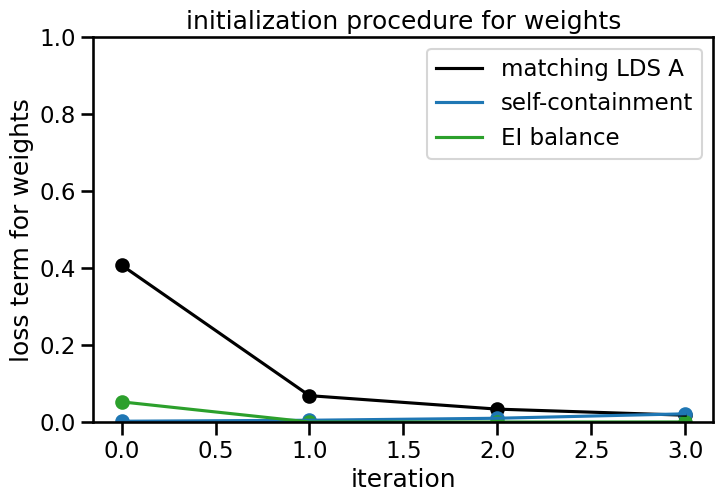

In [38]:
fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black', label='matching LDS A')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('initialization procedure for weights')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')
axes.set_ylim(0,1)

In [39]:
# J_perp = np.eye(N) - J_inv @ J
J_perp = scipy.linalg.null_space(J).T # null space is orthogonal complement to row(J)
print(J_perp.shape)
J_full = np.concatenate((J,J_perp), axis=0)

Uh, S, Vh = np.linalg.svd(J_full)
print(S)


(48, 50)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


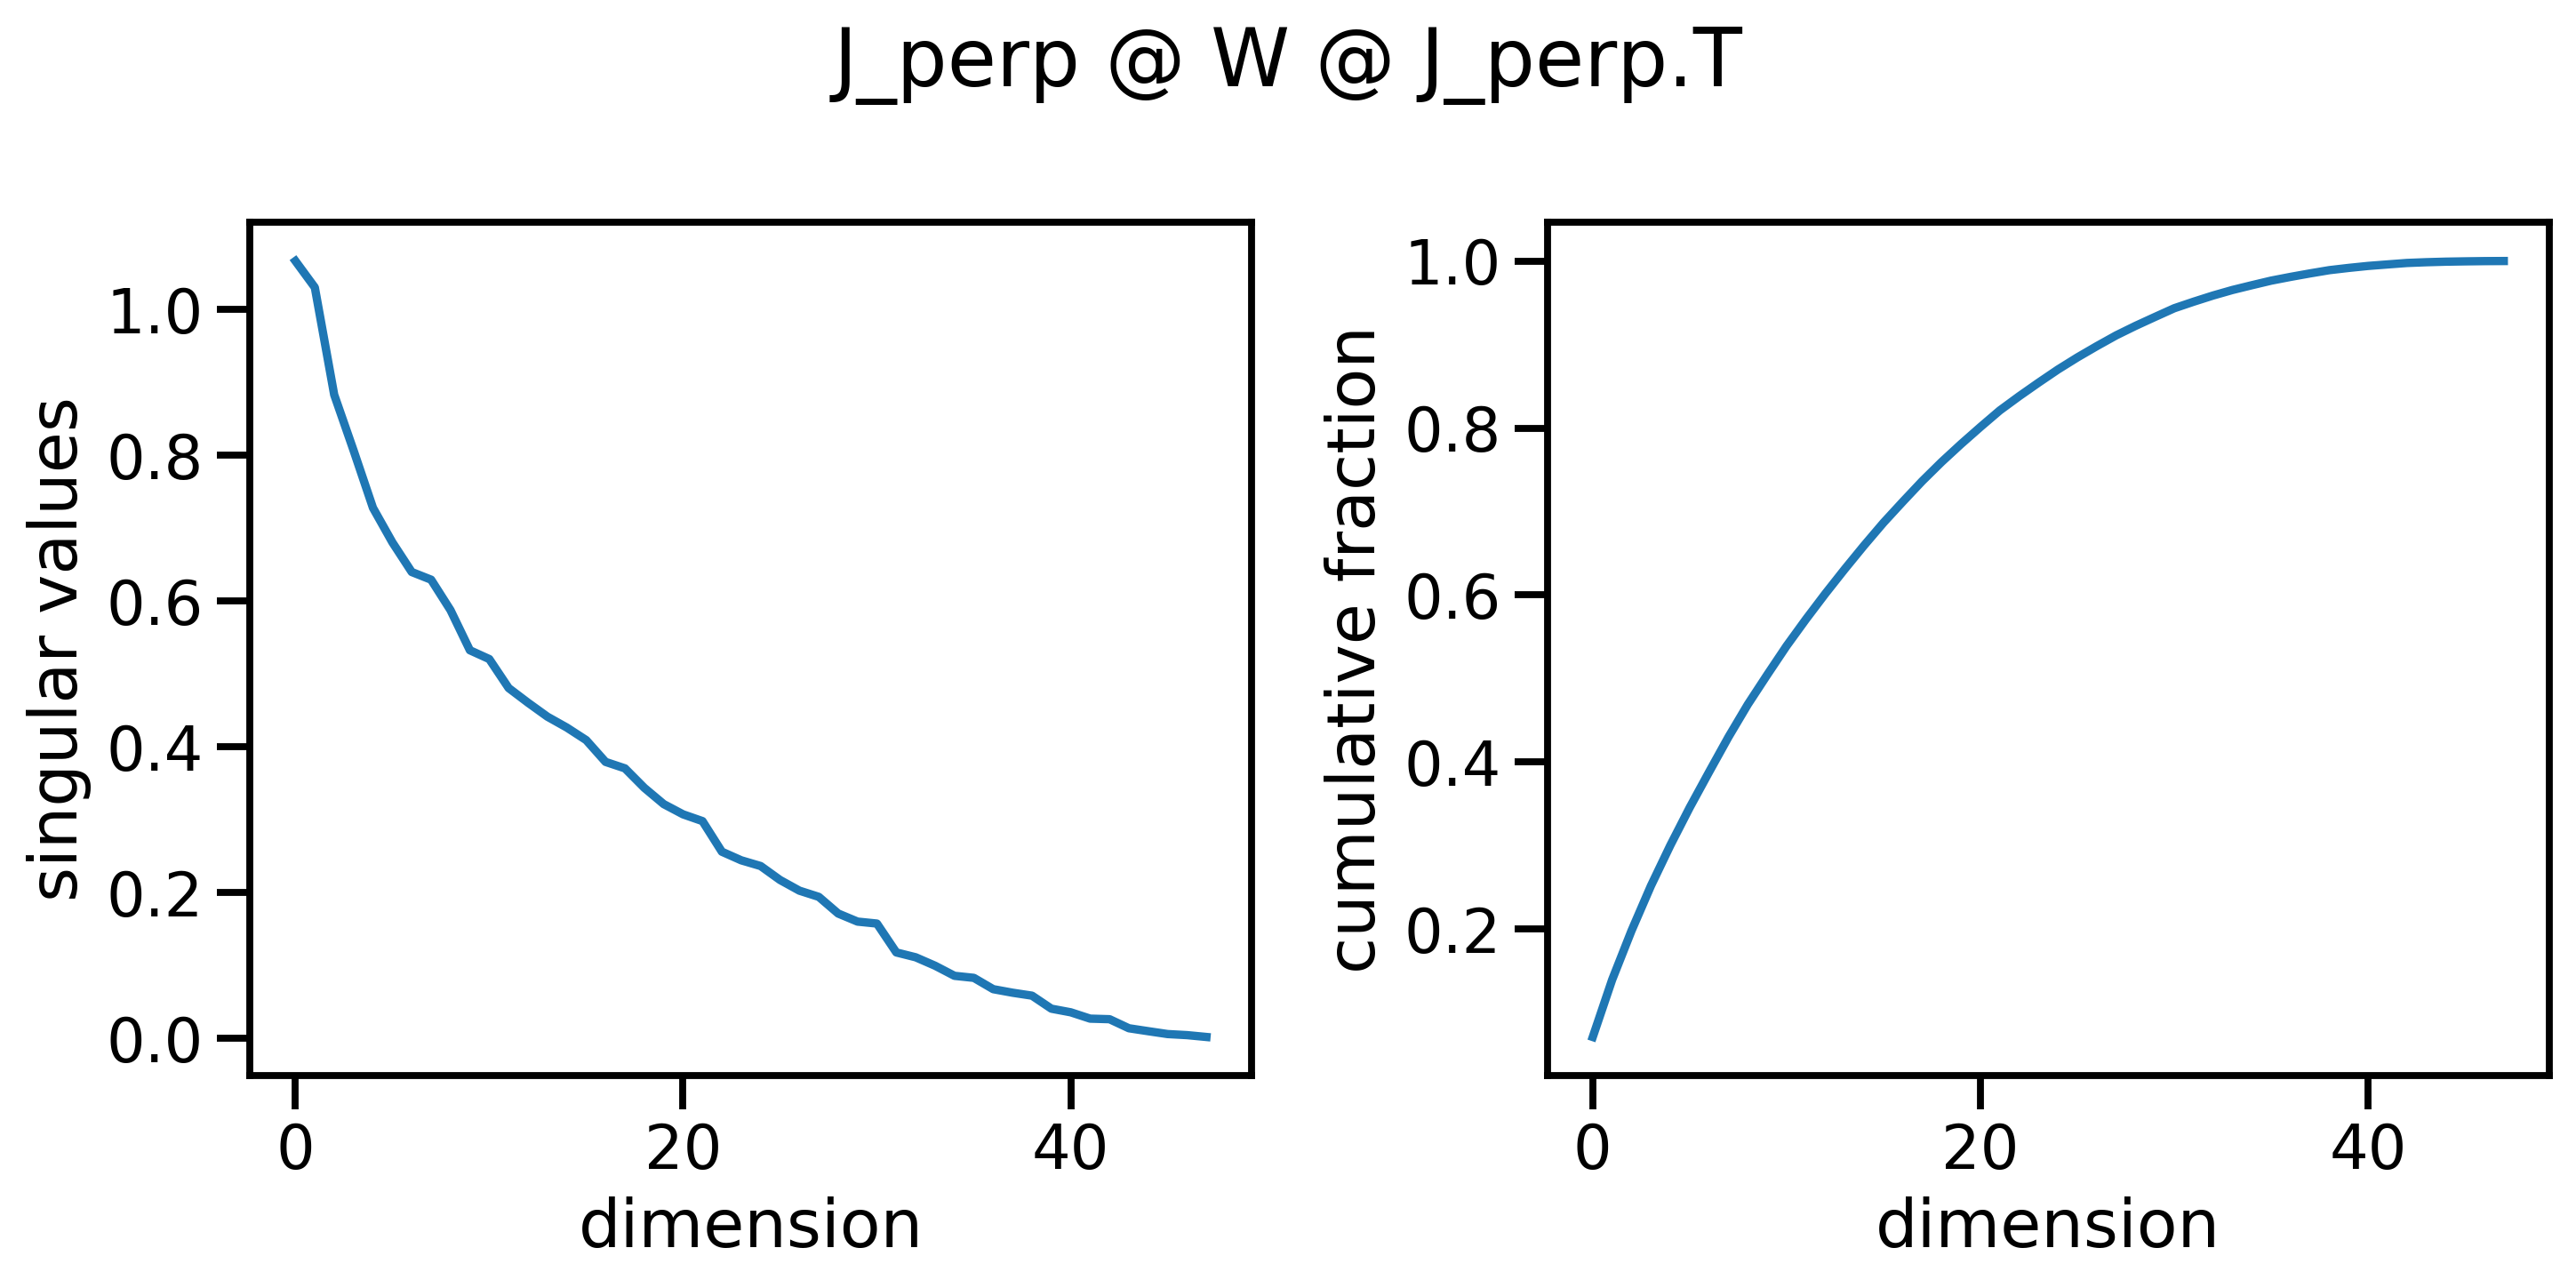

In [40]:
# Do PCA to see how much variance exists in J_perp W J_perp ^ T

W22 = J_perp @ initW @ J_perp.T
Uh, S, Vh = np.linalg.svd(W22)

frac_cumul = np.zeros((S.shape[0]))
for i in range(S.shape[0]):
    frac_cumul[i] = np.sum(S[:i+1])
frac_cumul = frac_cumul / np.sum(S)

fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=300)
axes[0].plot(S)
axes[0].set_ylabel('singular values')
fig.suptitle('J_perp @ W @ J_perp.T')
axes[1].set_ylabel('cumulative fraction')
axes[0].set_xlabel('dimension')
axes[1].set_xlabel('dimension')
axes[1].plot(frac_cumul)
fig.tight_layout()


In [41]:
# generate network activity
b, s, mu0, Q0, C_, d, R = RNN.generate_parameters(D, K1)
v = RNN.generate_network_activity(U, T, initW, b, s, mu0, Q0)

(48, 48)


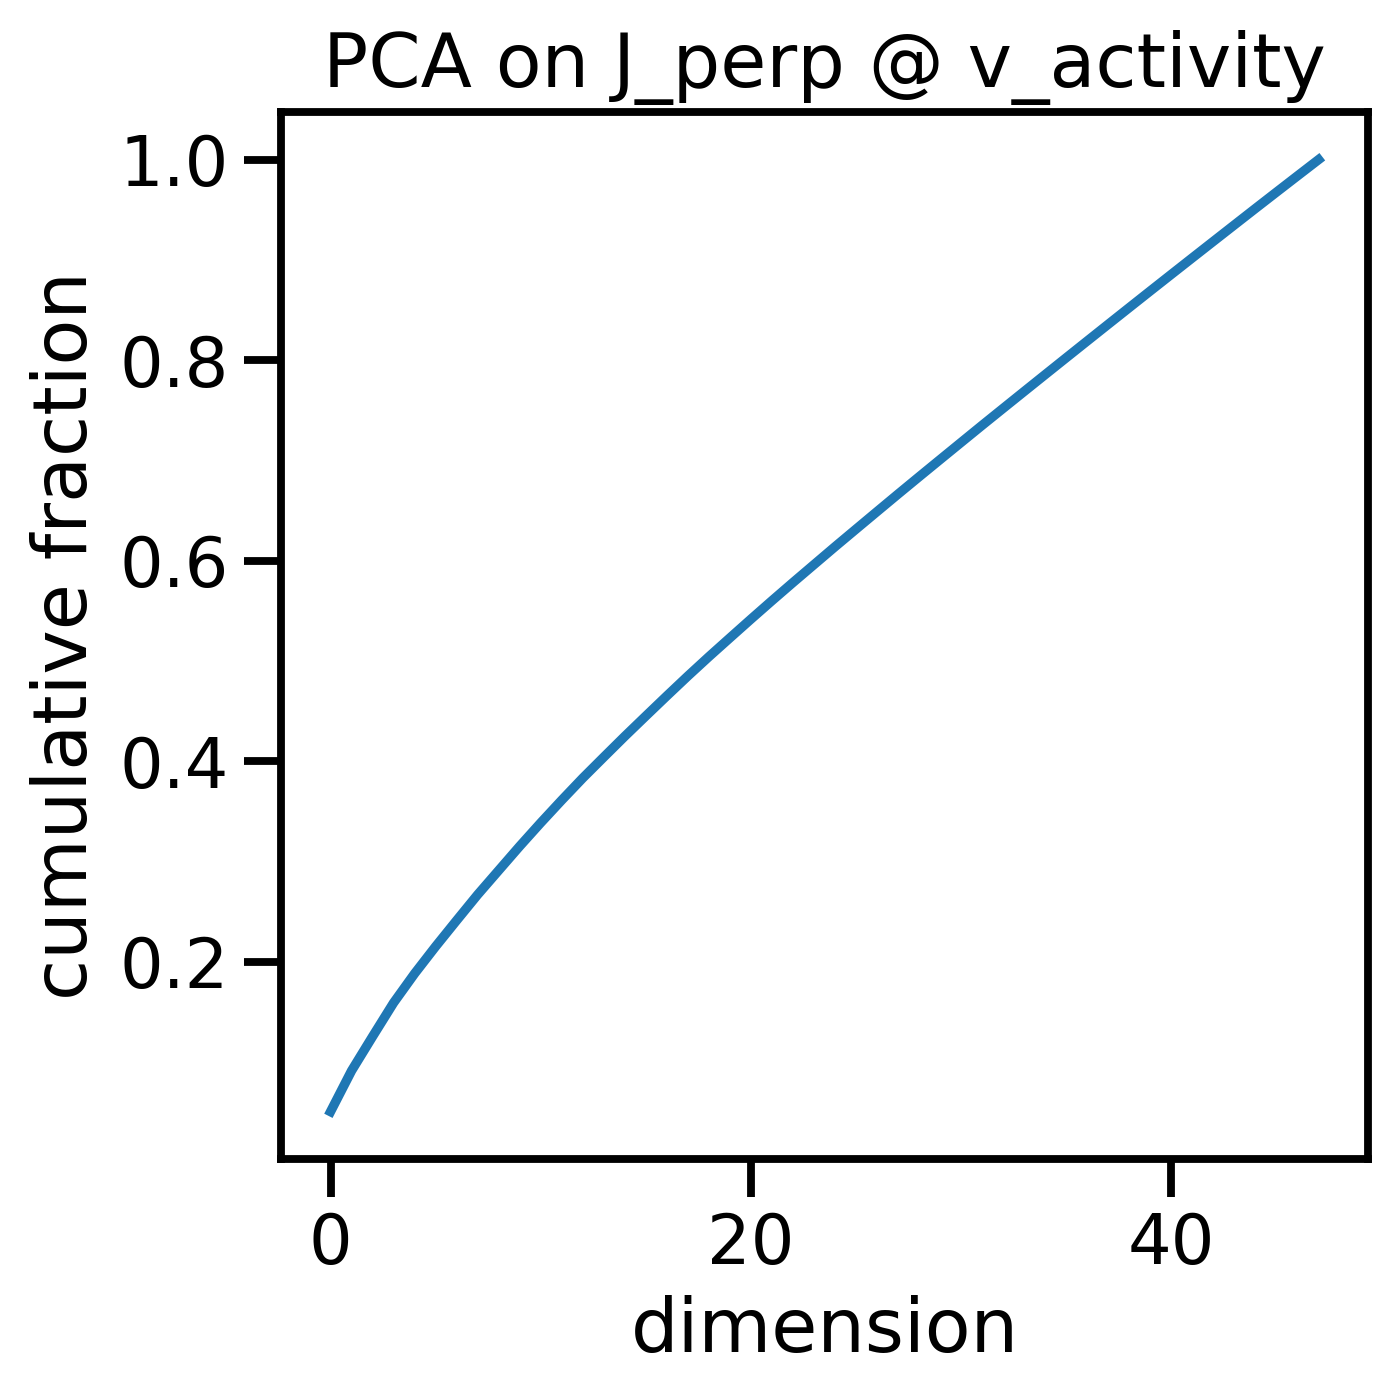

In [43]:
# project network activity in J_perp and do PCA
v_concat = v.reshape(v.shape[0]*v.shape[1],v.shape[2])

v_perp = v_concat @ J_perp.T
cov_perp = v_perp.T @ v_perp
Uh, S, Vh = np.linalg.svd(cov_perp)
print(cov_perp.shape)
frac_cumul = np.zeros((cov_perp.shape[0]))
for i in range(cov_perp.shape[0]):
    frac_cumul[i] = np.sum(S[:i+1])
frac_cumul = frac_cumul / np.sum(S)

fig, axes = plt.subplots(dpi=300,figsize=(5,5))
axes.plot(frac_cumul)
axes.set_ylabel('cumulative fraction')
axes.set_xlabel('dimension')
axes.set_title('PCA on J_perp @ v_activity')
fig.tight_layout()



In [ ]:
b, s, mu0, Q0, C_, d, R = RNN.generate_parameters(D,K1)
true_x, true_y = RNN.generate_latents_and_observations(U, T, A11, b, s, mu0, Q0, C_, d, R)

In [30]:
# saving 

np.savez(f'models/K1={K1}_K2={K2}_true_parameters_EI-RNN', A=A11, W=initW, v=v)
